*Luis Antonio Ortega Andrés   
Antonio Coín Castro*

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, IBMQ, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_textbook.tools import array_to_latex
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load IBM account
provider = IBMQ.load_account()

/home/antcc/.local/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


# Algoritmo cuántico de estimación de fase



Mostramos el desarrollo del algoritmo cuántico para estimación de la fase de un autovalor de una puerta cuántica. Suponemos que tenemos una puerta $U$ de $m$ qubits y conocemos un autovector $|\psi\rangle$ con autovalor asociado $e^{2\pi i \theta}$. El objetivo del algoritmo es estimar $e^{2\pi i \theta}$, que equivale a estimar $\theta$, donde estamos suponiendo que $0\leq \theta \leq 1$.

## Descripción del algoritmo QPE

El circuito que implementa el algoritmo (que describiremos a continuación) es el siguiente:

<img src="https://qiskit.org/textbook/ch-algorithms/images/qpe_tex_qz.png" alt="quantum phase estimation circuit" width=500></img>

Veamos las fases de las que consta el algoritmo.

### Inicialización

Elegimos un valor $n$ que representa el número de bits de precisión con el que queremos aproximar $\theta$. Consideramos dos registros cuánticos: en el primero (llamado registro de conteo) tendremos $n$ qubits inicializados a $|0\rangle$, y en el segundo tendremos $m$ qubits inicializados al estado $|\psi\rangle$.

Así, el estado inicial del sistema será:

$$|\psi_0\rangle = |0\rangle^{\otimes n}|\psi\rangle.$$

### Superposición de estados

Aplicamos una puerta de Hadamard a cada qubit del registro de conteo, por lo que el nuevo estado del circuito será:

$$|\psi_1\rangle = H^{\otimes n}|0\rangle^{\otimes n}|\psi\rangle = \frac{1}{2^{n/2}}\left(|0\rangle + |1\rangle\right)^{\otimes n}|\psi\rangle.$$

### Phase kickback de $|\psi\rangle$ 

Ahora utilizamos la idea del algoritmo de *phase kickback* que vimos en otro de los cuadernos para codificar la información de la fase del autovalor $e^{2\pi i \theta}$ en los $n$ qubits del registro de conteo. Para ello usaremos una propiedad evidente:

**Proposición.** Si $\lambda=e^{2\pi i \theta}$ es un autovalor de $U$ asociado al autovector $|\psi\rangle$, entonces $\lambda^j=e^{2\pi i j\theta}$ es un autovalor de $U^j$ asociado al mismo autovector, para todo $j\in \mathbb N$.

*Demostración.* Dado $j>1$, se tiene que:

$$U^j|\psi \rangle = U^{j-1}U|\psi\rangle = U^{j-1}\lambda|\psi\rangle = \lambda U^{j-2}U|\psi\rangle = \dots = \lambda^j|\psi\rangle.$$

Lo que hacemos entonces es codificar una potencia $2^j$ de $e^{2\pi i \theta}$ en el $j$-ésimo qubit del registro de conteo, para $j=0,1,\dots, n-1$. Sabemos que esto se puede conseguir aplicando una puerta Controlled-$U^{2^j}$ al registro que contiene $|\psi\rangle$, utilizando como qubit de control aquel donde queremos codificar la información. A la hora de aplicar las puertas lo hacemos en orden inverso para seguir la convención de Qiskit:

$$|\psi_2\rangle = \frac{1}{2^{n/2}}\left(|0\rangle + e^{2\pi i 2^{n-1}\theta}|1\rangle\right)\otimes \dots \otimes \left(|0\rangle + e^{2\pi i 2^{0}\theta}|1\rangle\right)\otimes |\psi\rangle.$$

*Nota: ver el cuaderno sobre el algoritmo de phase kickback para ver la derivación de esta fórmula.*

Por otro lado, si denotamos $|k\rangle$ al qubit $n$-dimensional dado por la representación binaria del número decimal $k$ con $n$ bits (es decir, $|k\rangle$ tiene un $1$ en la posición $k$-ésima y $0$s en el resto), con algunas manipulaciones algebraicas podemos reescribir lo anterior como:

$$|\psi_2\rangle=\frac{1}{2^{n/2}} \sum_{k=0}^{2^n - 1} e^{2\pi i k \theta}|k\rangle\otimes |\psi\rangle.$$

### Transformada de Fourier cuántica inversa

[Se puede demostrar](https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html) que la puerta cuántica conocida como *transformada de Fourier cuántica* ($\mathcal{QFT}$) aplicada a un qubit básico genérico $|x\rangle$ de dimensión $n$ (siguiendo la notación introducida anteriormente) tiene la siguiente expresión:

$$\mathcal{QFT}|x\rangle = \frac{1}{2^{n/2}}\sum_{k=0}^{2^n -1} e^{2\pi i kx/2^n}|k\rangle.$$

Nos damos cuenta entonces que esto es justamente lo que tenemos en la expresión anterior de $|\psi_2\rangle$, tomando $x=2^n\theta$. Por tanto, como la puerta $\mathcal {QFT}$ es reversible (como puerta cuántica que es), podemos en principio aplicar su puerta inversa, $\mathcal {QFT}^{-1}$, para recuperar el estado $|2^n\theta\rangle$.

Análogamente a lo anterior, la transformada cuántica de Fourier inversa tiene la expresión:

$$\mathcal{QFT}^{-1}|y\rangle = \frac{1}{2^{n/2}}\sum_{x=0}^{2^n -1} e^{-2\pi i xy/2^n}|x\rangle.$$

Por tanto, aplicando esta puerta a los $n$ primers qubits en la expresión de $|\psi_2\rangle$, se tiene (ya que la puerta $\mathcal {QFT}$ es lineal):

$$|\psi_3\rangle = \mathcal{QFT}^{-1}\left(\frac{1}{2^{n/2}} \sum_{k=0}^{2^n - 1} e^{2\pi i k \theta}|k \rangle\right) \otimes |\psi\rangle =\frac{1}{2^{n/2}} \sum_{k=0}^{2^n - 1} e^{2\pi i k \theta} \mathcal{QFT}^{-1}|k\rangle \otimes |\psi\rangle= \frac{1}{2^{n/2}} \sum_{k=0}^{2^n - 1} e^{2\pi i k \theta} \frac{1}{2^{n/2}}\sum_{x=0}^{2^n -1} e^{-2\pi i kx/2^n}|x\rangle \otimes |\psi \rangle = \frac{1}{2^n}\sum_{x=0}^{2^n-1} \sum_{k=0}^{2^n-1} e^{-2\pi i k (x-2^n\theta)/2^n}|x\rangle \otimes |\psi\rangle.$$

### Medición aproximada de $\theta$

Hay un problema, y es que este intento de revertir la aplicación de la puerta solo funcionará en el caso de que $2^n\theta$ sea un entero (representando un número binario de longitud $n$). Para atacar el caso general, podemos expresar $2^n\theta = a + 2^n\delta$, donde $a$ es el entero más cercano a $2^n\theta$, y la diferencia $2^n\delta$ satisface $0\leq |2^n\delta|\leq 1/2$ (recordemos que $0\leq \theta \leq 1$). Entonces, podemos escribir:

$$|\psi_3\rangle=\frac{1}{2^n}\sum_{x=0}^{2^n-1} \sum_{k=0}^{2^n-1} e^{-2\pi i k (x-a)/2^n}e^{2\pi i k \delta}|x\rangle \otimes |\psi\rangle.$$

Ahora, recordamos que para obtener la probabilidad de medir un valor $x$ en un estado $\varphi$, no tenemos más que calcular $p(|x\rangle)=|\langle x|\varphi\rangle|^2$. Por tanto, se tiene que,midiendo solo en los $n$ qubits del primer registro:

$$p(|a\rangle)=|\langle a | \psi^{0,\dots,n-1}_3\rangle|^2=\left|\left\langle a \left| \frac{1}{2^n}\sum_{x=0}^{2^n-1} \sum_{k=0}^{2^n-1} e^{-2\pi i k (x-a)/2^n}e^{2\pi i k \delta}\right|x \right\rangle \right|^2=\frac{1}{2^{2n}}\left|\sum_{k=0}^{2^n-1}e^{2\pi i k\delta}\right|^2.$$

Para entender de dónde sale la última igualdad, podemos pensar que como $|a\rangle$ es un qubit básico, el vector que lo representa tendrá un $1$ en la posición $a$-ésima y $0$s en el resto (viendo $a$ en decimal). Por tanto, al hacer el producto escalar nos quedaremos solo con la componente $a$-ésima del vector que forma el *ket*, es decir, con

$$\sum_{k=0}^{2^n-1}e^{-2\pi i k(a-a)/2^n}e^{2\pi i k \delta} = \sum_{k=0}^{2^n-1}e^{2\pi i k\delta}.$$

Ahora dividimos por casos:

- Si $\delta=0$ (es decir, $a=2^n\delta$), entonces de la expresión anterior obtenemos $p(|a\rangle)=1$, por lo que en la salida mediremos siempre el valor $2^n\theta$ (en binario). Esto es, el estado final del circuito será

$$|\psi_4\rangle =|2^n\theta \rangle \otimes |\psi\rangle.$$

- Si $\delta\neq 0$, la expresión de $p(|a\rangle)$ constituye una serie geométrica que podemos sumar. Aprovechando que $|\delta|\leq 2^{-(n+1)}$ y utilizando algunas cotas trigonométricas, [se puede demostrar](https://en.wikipedia.org/wiki/Quantum_phase_estimation_algorithm#cite_note-ekert-3) que $p(|a\rangle)\geq \frac{4}{\pi^2} \approx 0.405$. Es decir, al menos en el $40$% de las veces obtendremos como salida del circuito la mejor aproximación de $2^n\theta$ con $n$ bits.

En cualquiera de los casos, una vez que medimos la salida, tan solo tenemos que dividir el resultado por $2^n$ para obtener nuestra aproximación de $\theta$.

*Nota: también [es posible probar](https://arxiv.org/pdf/quant-ph/9708016.pdf) que podemos incrementar la probabilidad de obtener lo que queremos hasta $1-\varepsilon$ utilizando $\mathcal O\left(\log \varepsilon^{-1} \right)$ qubits extra en el registro de conteo, y después redondeando el resultado hasta los $n$ bits más significativos.*

## Ejemplo para aproximar el número $\pi$

Aprovechamos el algoritmo QPE descrito anteriormente para  intentar obtener una aproximación cuántica de $\pi$. Para ello lo primero que debemos hacer es buscar una puerta $U$ con un autovector $|\psi\rangle$ y una fase que nos convenga. Por ejemplo, consideramos la puerta

$$u_1(\rho)=\begin{pmatrix}1&0\\0&e^{i\rho}\end{pmatrix}.$$

Se comprueba fácilmente que $|1\rangle$ es un autovector de $U$, con autovalor asociado $e^{i\rho}$:

$$U|1\rangle = \begin{pmatrix}1&0\\0&e^{i/\rho}\end{pmatrix}\begin{pmatrix}0\\1\end{pmatrix}= e^{i\rho}\begin{pmatrix}0\\1\end{pmatrix}.$$

Si seleccionamos $U=u_1\left(1\right)$, el autovalor correspondiente será $e^i$. Comparando con la forma genérica $e^{2\pi i\theta}$ que supone el algoritmo QPE, nos damos cuenta de que realmente estaríamos estimando el valor $\theta=\frac{1}{2\pi}.$ Además, tras la medición del circuito QPE obtenemos un valor $a$ que representa (con alta probabilidad) la estimación de $2^n\theta$, por lo que nuestra estimación final será:

$$2^n\frac{1}{2\pi} = 2^n\theta \approx a \implies \pi \approx \frac{2^n}{2a}=\frac{2^{n-1}}{a}.$$

### Construcción del circuito

Creamos una serie de funciones para construir el circuito QPE. La primera de ellas será una que implementa la transformada cuántica de Fourier inversa.

In [2]:
# adapted from https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html
def qft_dagger(circ, n_qubits):
    """n-qubit QFTdagger the first n qubits in circ"""
    
    qft_inv = QuantumCircuit(n_qubits, name = "  Inverse QFT  ")
    for qubit in range(int(n_qubits/2)):
        qft_inv.swap(qubit, n_qubits-qubit-1)
    for j in range(0, n_qubits):
        for m in range(j):
            qft_inv.cu1(-np.pi/float(2**(j-m)), m, j)
        qft_inv.h(j)
        
    circ.append(qft_inv.to_instruction(), range(n_qubits))

A continuación escribimos una función que sitúa el circuito en el estado inicial adecuado, es decir, aplica una puerta de Hadamard a cada qubit del registro de conteo, y establece el estado $|\psi\rangle=|1\rangle$ en el otro registro.

In [11]:
# adapted from https://qiskit.org/textbook/ch-demos/piday-code.html
def qpe_pre(circ, n_qubits):
    circ.h(range(n_qubits))
    circ.x(n_qubits)

    for x in reversed(range(n_qubits)):
        for _ in range(2**(n_qubits-1-x)):
            circ.cp(1, n_qubits-1-x, n_qubits)

También escribimos una función para ejecutar el circuito y obtener los resultados.

In [4]:
def run_job(circ, backend, shots=1024):
    job = execute(circ, backend=backend, shots=shots)
    return job.result().get_counts(circ)

Escribimos una función que se encarga de construir el circuito con el número de qubits que le indiquemos, y la ejecutamos por ejemplo con $3$ qubits para poder visualizarlo.

In [12]:
def qpe_circ(n_qubits):
    # Create and initialize the circuit
    circ = QuantumCircuit(n_qubits + 1, n_qubits)
    qpe_pre(circ, n_qubits)
    circ.barrier()
    
    # Apply the inverse fourier transform
    qft_dagger(circ, n_qubits)
    circ.barrier()
    
    # Measure all but the last qubit
    circ.measure(range(n_qubits), range(n_qubits))

    return circ

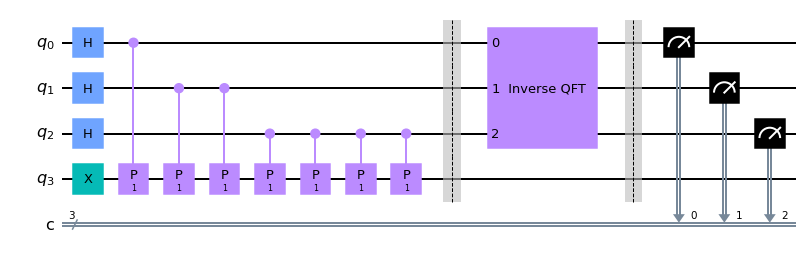

In [13]:
n = 3
qpe = qpe_circ(n)
qpe.draw('mpl')

Ejecutamos el algoritmo en el simulador.

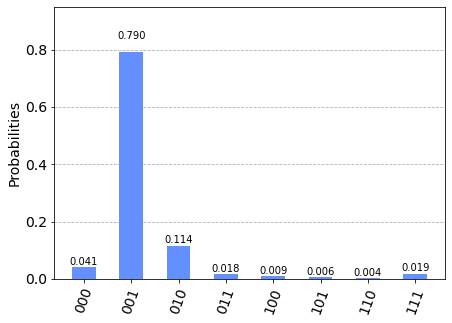

In [7]:
backend_sim = provider.get_backend('ibmq_qasm_simulator')
counts = run_job(qpe, backend_sim)
plot_histogram(counts)

Vemos que hemos obtenido como salida más probable $001$, es decir, $1$ en decimal. Según nuestros cálculos anteriores, podemos entonces recuperar el valor de $\pi$ como:

$$\pi \approx \frac{2^2}{1}=4.$$

Como vemos, no es una aproximación muy buena, porque estamos utilizando muy pocos qubits. Vamos a escribir una función que realice la estimación de $\pi$ de forma automática para distintos valores de $n$, y mostraremos los resultados en el simulador.

In [8]:
def get_pi_estimate(n_qubits, backend, shots=4096):
    # Create and initialize the circuit
    circ = qpe_circ(n_qubits)

    # Run the job and get the results
    counts = run_job(circ, backend=backend, shots=shots)

    # Get the count that occurred most frequently
    max_counts_result = max(counts, key=counts.get)
    max_counts_result = int(max_counts_result, 2)
    
    # Solve for pi from the measured counts
    if max_counts_result > 0:
        pi = 1.0 * 2**(n_qubits-1)/max_counts_result
    else:
        pi = 0.0
    
    return pi, counts

In [9]:
# Estimate pi using different numbers of qubits
nqs = list(range(2, 13))
pi_estimates = []
for nq in nqs:
    pi_estimate, _ = get_pi_estimate(nq, backend_sim)
    pi_estimates.append(pi_estimate)
    print(f"{nq} qubits, pi ≈ {pi_estimate}")

2 qubits, pi ≈ 2.0
3 qubits, pi ≈ 4.0
4 qubits, pi ≈ 2.6666666666666665
5 qubits, pi ≈ 3.2
6 qubits, pi ≈ 3.2
7 qubits, pi ≈ 3.2
8 qubits, pi ≈ 3.1219512195121952
9 qubits, pi ≈ 3.1604938271604937
10 qubits, pi ≈ 3.1411042944785277
11 qubits, pi ≈ 3.1411042944785277
12 qubits, pi ≈ 3.1411042944785277


Vemos que a partir de 10 qubits la aproximación es correcta hasta la tercera cifra decimal, por lo que tenemos ya una buena aproximación. Podemos visualizar también los resultados en una gráfica.

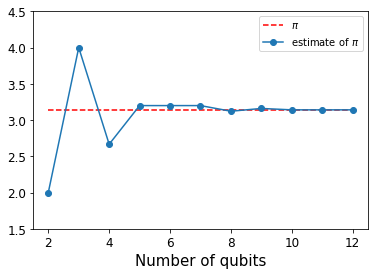

In [10]:
plt.plot(nqs, [np.pi]*len(nqs), '--r')
plt.plot(nqs, pi_estimates, '.-', markersize=12)
plt.xlim([1.5, 12.5])
plt.ylim([1.5, 4.5])
plt.legend(['$\pi$', 'estimate of $\pi$'])
plt.xlabel('Number of qubits', fontdict={'size':15})
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.show()